# Perfil de Densidade a partir da simulação de um poço</br>

### Script desenvolvido por Victor Carreira
### Colaboração de Rodrigos Mota e Bijani

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import pylab as py
import skimage as sk
import imageio as io
from scipy.misc import imread, imsave, imresize
import plotly as ply
import plotly.plotly as plyy
import plotly.graph_objs as go
import pandas as pd
import random

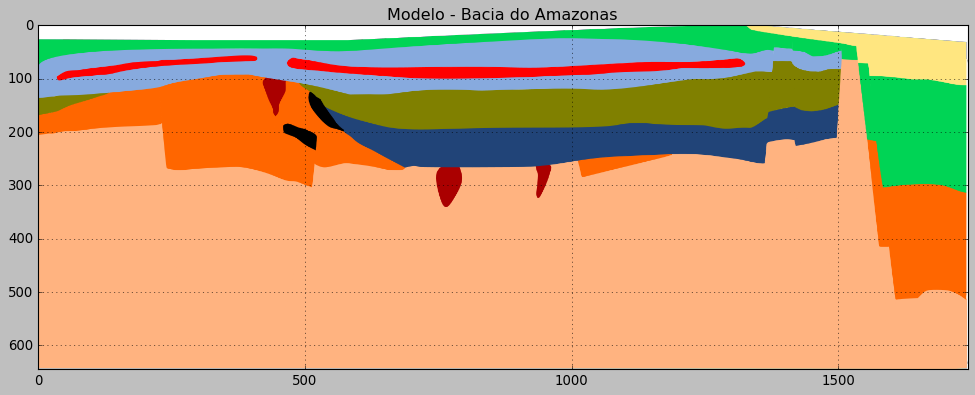

In [2]:
#Leitura da imagem (.png) com o modelo geológico
ma = io.imread("../figs/amazonas.png", as_gray=False, pilmode="RGBA") # verificar no inkscape!
plt.style.use(['classic'])
py.rcParams['figure.figsize'] = (15.0, 20.0) #new figure dimension
plt.title("Modelo - Bacia do Amazonas")
plt.imshow(ma)
plt.grid()
plt.show()

In [3]:
#Criando os vetores de coordenadas (xi), com 7000m e o vetor de profundidade (zi), com 2000m.
hy = np.shape(ma)[0]
hx = np.shape(ma)[1]
hz = np.shape(ma)[2]

xi = np.linspace(0.0, 7000.0, hx, endpoint=True)
zi = np.linspace(0.0, 2000.0, hy, endpoint=True)

In [18]:
# para fazer plots dentro do proprio script sem a necessidade de conexao com a internet:
ply.offline.init_notebook_mode(connected=True)

# funcao go.Contour faz um countour plot usando como eixo x, o xi criado para coordenadas, como o eixo y, o zi
# criado para profunidades, e como o eixo z o plot de valores RGBA da matriz ma.
# além disso, na função go.countour está listando as configurações pernsonalizadas para o colorbar

imagem = go.Heatmap(z=ma[:,:,0],
                         x=xi,
                         y=zi,
                    colorbar=dict(
                        title='RGBA',
                        titleside='right',
                        titlefont=dict(
                            size=14,
                            family='Arial, sans-serif'
                        ),
                        thickness=25,
                        thicknessmode='pixels',
                        len=0.9,
                        lenmode='fraction',
                        outlinewidth=0
                    )
                   )
          

# a função go.Layout personaliza o layout do gráfico, no caso, colocando título nos eixos.
# "autorange=reversed", da o comando para inverter o eixo y, no caso as profundidades, começando com 0 e os
# aumentando p/ baixo.
layout = go.Layout(
            xaxis= dict(title='Distância',
                        side ='top',
                        color = 'white'
                   ),
            yaxis= dict(title='Profundidade',
                        autorange='reversed',
                        color = 'white'
                   ),
            # define o tamanho do gráfico, altura e largura, e o tamanhado da margem (l=left, r=right, b=bottom, t=top)
            autosize=False,
            width=1000,
            height=500,
            margin=go.layout.Margin(
                l=50,
                r=30,
                b=20,
                t=60
            ),
            paper_bgcolor='#7f7f7f', #cor do background da margem
            plot_bgcolor='#c7c7c7' #cor do backgroud do gráfico
    )

# a função go.FigureWidget cria o a figura com os parametros utilizados na go.Countour e o layout na go.Layout
fig = go.FigureWidget(data=[imagem], layout=layout)

#Selecionando as configurações dos dados de fig
teste = fig.data[0]
x_data = []
y_data = []
indx = []
indy = []

indy_par = []
indx_par = []
indy_impar = []
indx_impar = []
# criando a função de callback
# para selecionar o ponto inicial e final da perfuração simulada do poço sintético 
def select_point(trace, points, selector):
    x = list(teste.x)
    y = list(teste.y)
    print(selector)
    for i in points.point_inds:
        y_data.append(zi[i[0]])
        x_data.append(xi[i[1]])
        indx.append(i[1])
        indy.append(i[0])
        
        if selector.shift == True:
            indy_par.append(i[0])
            indx_par.append(i[1])
        if selector.shift == False:
            indy_impar.append(i[0])
            indx_impar.append(i[1])
        print(points.point_inds)

# Sempre que clicar no gráfico chamará a função de callback
teste.on_click(select_point)

# plot a figura na tela:
fig

####### É NECESSÁRIO ESCOLHER DOIS PONTOS CLICANDO NO GRÁFICO GERADO PARA RODAR O RESTANTE DO SCRIPT #######

FigureWidget({
    'data': [{'colorbar': {'len': 0.9,
                           'lenmode': 'fraction',
      …

InputDeviceState(
    ctrl=False, 
    alt=False, 
    shift=True, 
    meta=False, 
    button=0, 
    buttons=1)
[[27, 258]]
InputDeviceState(
    ctrl=False, 
    alt=False, 
    shift=False, 
    meta=False, 
    button=0, 
    buttons=1)
[[456, 287]]
InputDeviceState(
    ctrl=False, 
    alt=False, 
    shift=True, 
    meta=False, 
    button=0, 
    buttons=1)
[[44, 1594]]
InputDeviceState(
    ctrl=False, 
    alt=False, 
    shift=False, 
    meta=False, 
    button=0, 
    buttons=1)
[[518, 1605]]


In [11]:
# para fazer plots dentro do proprio script sem a necessidade de conexao com a internet:
ply.offline.init_notebook_mode(connected=True)

# funcao go.Contour faz um countour plot usando como eixo x, o xi criado para coordenadas, como o eixo y, o zi
# criado para profunidades, e como o eixo z o plot de valores RGBA da matriz ma.
# além disso, na função go.countour está listando as configurações pernsonalizadas para o colorbar

imagem = go.Heatmap(z=ma[:,:,0],
                         x=xi,
                         y=zi,
                    colorbar=dict(
                        title='RGBA',
                        titleside='right',
                        titlefont=dict(
                            size=14,
                            family='Arial, sans-serif'
                        ),
                        thickness=25,
                        thicknessmode='pixels',
                        len=0.9,
                        lenmode='fraction',
                        outlinewidth=0
                    )
                   )
          

# a função go.Layout personaliza o layout do gráfico, no caso, colocando título nos eixos.
# "autorange=reversed", da o comando para inverter o eixo y, no caso as profundidades, começando com 0 e os
# aumentando p/ baixo.
layout = go.Layout(
            xaxis= dict(title='Distância',
                        side ='top',
                        color = 'white'
                   ),
            yaxis= dict(title='Profundidade',
                        autorange='reversed',
                        color = 'white'
                   ),
            # define o tamanho do gráfico, altura e largura, e o tamanhado da margem (l=left, r=right, b=bottom, t=top)
            autosize=False,
            width=1000,
            height=500,
            margin=go.layout.Margin(
                l=50,
                r=30,
                b=20,que o programa lê a quantidade de dedos que cada jogador colocou, eu preciso de uma form
                t=60
            ),
            paper_bgcolor='#7f7f7f', #cor do background da margem
            plot_bgcolor='#c7c7c7' #cor do backgroud do gráfico
    )

imagem2 = go.Scatter(x=x_data,y=y_data)

data = [imagem, imagem2]

fig = go.FigureWidget(data=data, layout=layout)

# plot a figura na tela:
fig

FigureWidget({
    'data': [{'colorbar': {'len': 0.9,
                           'lenmode': 'fraction',
      …

### Para mais de um poço sintético

In [54]:
#simulando a perfuração de mais de um poço sintético
#definindo a dimensão de cada poço sintético
mb = []
for j in range (len(indx_par)):
    mb.append(ma[indy_par[j]-1:indy_impar[j], indx_par[j]-1:indx_par[j]])

#print((mb[0]))

### Para apenas um poço sintético

In [56]:
#apenas rodar quando escolher dois pontos clicando no gráfico acima
#definindo a dimensão do poço sintético
mb = (ma[indy[0]-1:indy[1], indx[0]-1:indx[0]])

### Leitura do banco de dados de input, fornecido pelo usuario (litologias, RBG, rho)

In [ ]:
cab = ['lito', 'R','G','B','A', 'rho']
data = pd.read_csv('../dados/input_usuario.txt', sep='\s+', names=cab, header=0 )
print(data)

## Teste para comparar litologias do poço perfurado com a cor estabelecida:


In [ ]:
# Calculando a norma euclidiana para cada litologia, distancia entre o R, G, B e A:
D = (data.R**2 + data.G**2 + data.B**2 + data.A**2)**0.5
#adicionando a coluna 'DistCor' na tabela de dados:
data['DistCor'] = D

In [57]:
# Calculando a norma euclidiana para cada profundidade do poço mb, distancia entre o R, G, B e A:
lito = []
for i in range(len(mb)):
    de = (mb[i,0,0]**2 + mb[i,0,1]**2 + mb[i,0,2]**2 + mb[i,0,3]**2)**0.5
    lito.append(de)

In [ ]:
# construindo o perfil de densidade:
rhob = [0.0]*len(lito)

for i in range(len(lito)):
    for k in range(len(data.lito)):
        if lito[i] == data.DistCor[k]: 
            rhob[i] = data.rho[k]
#print(rhob)

In [ ]:
## Adiconando ruído randômico gaussiano normal:
rhob_noise = np.zeros( len(rhob) )

for i in range(len(rhob)):
    rhob_noise[i] = random.gauss(rhob[i], 0.6)

In [ ]:
#Criando o vetor de profundidade do poço:
prof = np.linspace(zi[indy[0]], zi[indy[1]], len(rhob))

In [ ]:
# para fazer plots dentro do proprio script sem a necessidade de conexao com a internet:
ply.offline.init_notebook_mode(connected=True)

# funcao go.Scatter faz um scatter plot usando como eixo x, o singnal_RHObm criado com os dados de rhob e
# adicionado ruído, como o eixo y, a prof criada para profunidades

rhob_graph = [go.Scatter(x=rhob_noise, y=prof)]

# Define o layout do plot, como título dos eixos, posição dos eixos, cor da letra, etc
layout = go.Layout(
    xaxis= dict(title='Propriedade Fisica',
                side ='top',
                color = 'white'
               ),
    yaxis= dict(title='Profundidade',
                autorange='reversed',
                color = 'white'
               ),
    # define o tamanho do gráfico, altura e largura, e o tamanhado da margem (l=left, r=right, b=bottom, t=top)
    autosize=False,
    width=400,
    height=800,
    margin=go.layout.Margin(
        l=50,
        r=30,
        b=20,
        t=60
        ),
    paper_bgcolor='#7f7f7f', #cor do background da margem
    plot_bgcolor='#c7c7c7' #cor do backgroud do gráfico
    )

fig = go.FigureWidget(data=rhob_graph, layout=layout)

fig

## TODO:
### 1) Usar o plotly para plotar o poço interativamente, ou seja, no "ato de perfilar" com os cliques do mouse;   
### 2) Criar poços direcionais (futuro);
### 3) Como seria fazer vários poços na mesma janela de plot? (QUASE)
### 4) Limpar o codigo criando funções (plolty, da distanica dos RBG)
### 5) fazer o perfil de VS a partir de rhob (Gardner)
### NOVO TODO:
### 1.1) Generalizar para N litologias (atualmente são cinco); (FEITO)


# Para saber mais sobre a go.Countour:

### https://plot.ly/python/contour-plots/
### https://plot.ly/python/click-events/#update-points-using-a-click-callback